In [1]:
import os
import numpy as np
from pathlib import Path
import json
import collections
import torch
import torch.utils.data
from PIL import Image

In [2]:
class KCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, jsonname, transforms = None):
        self.root = root
        self.PATH = Path(root)        
        self.jsonname = jsonname
        self.transforms =  transforms                
        
        trn_j = json.load( (self.PATH/jsonname).open() )        
        self.images = trn_j['images']
        #self.annotations = trn_j['annotations']
        self.cats =  {o['id']:o['name'] for o in trn_j['categories']}
        self.trn_fns = {o['id']:o['file_name'] for o in trn_j['images']}
        self.trn_ids = [o['id'] for o in trn_j['images']]        
        
        self.trn_anno = collections.defaultdict( lambda:[] )
        for o in trn_j['annotations']:
            if not o['ignore']:
                bb = o['bbox']
                #bb = hw_bb(bb)
                self.trn_anno[o['image_id']].append((bb, o['category_id'], o['area'], o['iscrowd']))        
    
    def __getitem__(self, idx):
        img_id = self.trn_ids[idx]
        img_name = self.trn_fns[img_id]
        #print("img_id", img_id)
        #print("img_name", img_name)
        JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
        img = Image.open( self.PATH/JPEGS/img_name ).convert("RGB")

        boxes = []
        labels = []
        areas = []
        iscrowds = []
        for o in self.trn_anno[img_id]:
            #print("o", o)
            x = o[0][0]
            y = o[0][1]
            width = o[0][2]
            height = o[0][3]            
            boxes.append( [x, y, x + width -1, y + height -1] )
            
            labels.append(o[1])
            areas.append(o[2])
            iscrowds.append(o[3])
            
        target = {}                
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowds = torch.as_tensor(iscrowds, dtype=torch.int64)
        
        image_id = torch.tensor([img_id])        
        
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowds       
        
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len( self.images)

In [3]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]        
        

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            #print("xmin={}, ymin={}, xmax={}, ymax={}".format(xmin, ymin, xmax, ymax) )
            

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        
#         print("type(boxes)", type(boxes), boxes.shape)
#         print("type(labels)", type(labels), labels.shape)
#         print("type(image_id)", type(image_id), image_id.shape)
#         print("type(area)", type(area), area.shape)
#         print("type(iscrowd)", type(iscrowd), iscrowd.shape)
        

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes, pretrain):
    # load an instance segmentation model pre-trained pre-trained on COCO    
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrain)    

    
    in_features = model.roi_heads.box_predictor.cls_score.in_features    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []    
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device", device)

# our dataset has two classes only - background and person
num_classes = 20 + 1

# use our dataset and defined transformations
#dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
#dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

dataset = KCocoDataset('data/pascal', 'pascal_train2007.json', get_transform(train=True))
dataset_test = KCocoDataset('data/pascal', 'pascal_train2007.json', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes, True)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)    
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

SAVED_PATH = './voc20_epoch10_2019.06.26.nn.pt'
# save the target path.
torch.save(model.state_dict(), SAVED_PATH)
print("model saved.")

device cuda
Epoch: [0]  [   0/1226]  eta: 0:37:23  lr: 0.000010  loss: 3.4188 (3.4188)  loss_classifier: 3.1926 (3.1926)  loss_box_reg: 0.1686 (0.1686)  loss_objectness: 0.0358 (0.0358)  loss_rpn_box_reg: 0.0219 (0.0219)  time: 1.8296  data: 0.0401  max mem: 3550
Epoch: [0]  [  10/1226]  eta: 0:10:58  lr: 0.000060  loss: 3.3425 (3.3544)  loss_classifier: 3.0749 (3.0942)  loss_box_reg: 0.1784 (0.2196)  loss_objectness: 0.0178 (0.0213)  loss_rpn_box_reg: 0.0169 (0.0194)  time: 0.5419  data: 0.0189  max mem: 5217
Epoch: [0]  [  20/1226]  eta: 0:09:38  lr: 0.000110  loss: 3.1673 (2.9508)  loss_classifier: 2.8418 (2.6819)  loss_box_reg: 0.2127 (0.2352)  loss_objectness: 0.0058 (0.0161)  loss_rpn_box_reg: 0.0168 (0.0176)  time: 0.4119  data: 0.0155  max mem: 5482
Epoch: [0]  [  30/1226]  eta: 0:09:00  lr: 0.000160  loss: 1.7455 (2.3747)  loss_classifier: 1.3513 (2.1082)  loss_box_reg: 0.2526 (0.2346)  loss_objectness: 0.0111 (0.0149)  loss_rpn_box_reg: 0.0133 (0.0171)  time: 0.4018  data: 0.

Epoch: [0]  [ 320/1226]  eta: 0:06:00  lr: 0.001608  loss: 0.2612 (0.6975)  loss_classifier: 0.1197 (0.4694)  loss_box_reg: 0.1286 (0.1951)  loss_objectness: 0.0014 (0.0094)  loss_rpn_box_reg: 0.0204 (0.0235)  time: 0.4137  data: 0.0160  max mem: 5771
Epoch: [0]  [ 330/1226]  eta: 0:05:56  lr: 0.001658  loss: 0.2345 (0.6831)  loss_classifier: 0.1078 (0.4582)  loss_box_reg: 0.0986 (0.1919)  loss_objectness: 0.0024 (0.0093)  loss_rpn_box_reg: 0.0225 (0.0237)  time: 0.4114  data: 0.0147  max mem: 5771
Epoch: [0]  [ 340/1226]  eta: 0:05:52  lr: 0.001708  loss: 0.2383 (0.6743)  loss_classifier: 0.1078 (0.4499)  loss_box_reg: 0.0986 (0.1910)  loss_objectness: 0.0024 (0.0095)  loss_rpn_box_reg: 0.0256 (0.0238)  time: 0.3913  data: 0.0151  max mem: 5771
Epoch: [0]  [ 350/1226]  eta: 0:05:47  lr: 0.001758  loss: 0.3638 (0.6685)  loss_classifier: 0.1571 (0.4443)  loss_box_reg: 0.1397 (0.1905)  loss_objectness: 0.0032 (0.0097)  loss_rpn_box_reg: 0.0272 (0.0241)  time: 0.3901  data: 0.0167  max me

Epoch: [0]  [ 640/1226]  eta: 0:03:49  lr: 0.003207  loss: 0.3567 (0.5029)  loss_classifier: 0.1616 (0.3108)  loss_box_reg: 0.1358 (0.1598)  loss_objectness: 0.0081 (0.0093)  loss_rpn_box_reg: 0.0197 (0.0229)  time: 0.3970  data: 0.0159  max mem: 5771
Epoch: [0]  [ 650/1226]  eta: 0:03:45  lr: 0.003257  loss: 0.2124 (0.4989)  loss_classifier: 0.1008 (0.3081)  loss_box_reg: 0.0792 (0.1587)  loss_objectness: 0.0047 (0.0092)  loss_rpn_box_reg: 0.0207 (0.0229)  time: 0.3866  data: 0.0162  max mem: 5771
Epoch: [0]  [ 660/1226]  eta: 0:03:41  lr: 0.003307  loss: 0.2124 (0.4955)  loss_classifier: 0.1229 (0.3056)  loss_box_reg: 0.0792 (0.1580)  loss_objectness: 0.0027 (0.0091)  loss_rpn_box_reg: 0.0159 (0.0228)  time: 0.3881  data: 0.0186  max mem: 5771
Epoch: [0]  [ 670/1226]  eta: 0:03:38  lr: 0.003357  loss: 0.3056 (0.4926)  loss_classifier: 0.1487 (0.3030)  loss_box_reg: 0.1116 (0.1576)  loss_objectness: 0.0027 (0.0092)  loss_rpn_box_reg: 0.0166 (0.0229)  time: 0.4120  data: 0.0172  max me

Epoch: [0]  [ 960/1226]  eta: 0:01:44  lr: 0.004805  loss: 0.1992 (0.4247)  loss_classifier: 0.1177 (0.2534)  loss_box_reg: 0.0589 (0.1382)  loss_objectness: 0.0049 (0.0096)  loss_rpn_box_reg: 0.0166 (0.0234)  time: 0.3886  data: 0.0163  max mem: 6375
Epoch: [0]  [ 970/1226]  eta: 0:01:40  lr: 0.004855  loss: 0.2204 (0.4239)  loss_classifier: 0.1281 (0.2529)  loss_box_reg: 0.0691 (0.1380)  loss_objectness: 0.0063 (0.0097)  loss_rpn_box_reg: 0.0144 (0.0234)  time: 0.3881  data: 0.0165  max mem: 6375
Epoch: [0]  [ 980/1226]  eta: 0:01:36  lr: 0.004905  loss: 0.2564 (0.4229)  loss_classifier: 0.1386 (0.2520)  loss_box_reg: 0.0744 (0.1376)  loss_objectness: 0.0096 (0.0098)  loss_rpn_box_reg: 0.0227 (0.0236)  time: 0.3695  data: 0.0156  max mem: 6375
Epoch: [0]  [ 990/1226]  eta: 0:01:32  lr: 0.004955  loss: 0.1857 (0.4211)  loss_classifier: 0.1091 (0.2507)  loss_box_reg: 0.0480 (0.1371)  loss_objectness: 0.0106 (0.0098)  loss_rpn_box_reg: 0.0207 (0.0236)  time: 0.3615  data: 0.0159  max me

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.520
Epoch: [1]  [   0/1226]  eta: 0:07:59  lr: 0.005000  loss: 0.1379 (0.1379)  loss_classifier: 0.0437 (0.0437)  loss_box_reg: 0.0172 (0.0172)  loss_objectness: 0.0093 (0.0093)  loss_rpn_box_reg: 0.0676 (0.0676)  time: 0.3910  data: 0.0120  max mem: 6375
Epoch: [1]  [  10/1226]  eta: 0:07:26  lr: 0.005000  loss: 0.1600 (0.2317)  loss_classifier: 0.1029 (0.1245)  loss_box_reg: 0.0323 (0.0547)  loss_objectness: 0.0093 (0.0128)  loss_rpn_box_reg: 0.0345 (0.0397)  time: 0.3670  data: 0.0139  max mem: 6375
Epoch: [1]  [  20/1226]  eta: 0:07:33  lr: 0.005000  loss: 0.1875 (0.2363)  loss_classifier: 0.1

Epoch: [1]  [ 300/1226]  eta: 0:06:02  lr: 0.005000  loss: 0.2071 (0.2572)  loss_classifier: 0.1206 (0.1385)  loss_box_reg: 0.0690 (0.0866)  loss_objectness: 0.0040 (0.0081)  loss_rpn_box_reg: 0.0136 (0.0240)  time: 0.3969  data: 0.0153  max mem: 6375
Epoch: [1]  [ 310/1226]  eta: 0:05:58  lr: 0.005000  loss: 0.2034 (0.2544)  loss_classifier: 0.0984 (0.1369)  loss_box_reg: 0.0609 (0.0855)  loss_objectness: 0.0041 (0.0080)  loss_rpn_box_reg: 0.0125 (0.0240)  time: 0.3826  data: 0.0153  max mem: 6375
Epoch: [1]  [ 320/1226]  eta: 0:05:55  lr: 0.005000  loss: 0.1442 (0.2522)  loss_classifier: 0.0596 (0.1354)  loss_box_reg: 0.0496 (0.0848)  loss_objectness: 0.0038 (0.0079)  loss_rpn_box_reg: 0.0154 (0.0241)  time: 0.4029  data: 0.0159  max mem: 6375
Epoch: [1]  [ 330/1226]  eta: 0:05:51  lr: 0.005000  loss: 0.2339 (0.2546)  loss_classifier: 0.1061 (0.1368)  loss_box_reg: 0.0786 (0.0860)  loss_objectness: 0.0038 (0.0079)  loss_rpn_box_reg: 0.0154 (0.0239)  time: 0.4037  data: 0.0152  max me

Epoch: [1]  [ 620/1226]  eta: 0:03:56  lr: 0.005000  loss: 0.1873 (0.2487)  loss_classifier: 0.0838 (0.1332)  loss_box_reg: 0.0586 (0.0836)  loss_objectness: 0.0051 (0.0080)  loss_rpn_box_reg: 0.0150 (0.0238)  time: 0.3775  data: 0.0150  max mem: 6375
Epoch: [1]  [ 630/1226]  eta: 0:03:52  lr: 0.005000  loss: 0.1738 (0.2486)  loss_classifier: 0.0978 (0.1330)  loss_box_reg: 0.0637 (0.0836)  loss_objectness: 0.0060 (0.0081)  loss_rpn_box_reg: 0.0150 (0.0239)  time: 0.3872  data: 0.0153  max mem: 6375
Epoch: [1]  [ 640/1226]  eta: 0:03:48  lr: 0.005000  loss: 0.1921 (0.2486)  loss_classifier: 0.1076 (0.1329)  loss_box_reg: 0.0506 (0.0834)  loss_objectness: 0.0059 (0.0082)  loss_rpn_box_reg: 0.0150 (0.0241)  time: 0.4051  data: 0.0161  max mem: 6375
Epoch: [1]  [ 650/1226]  eta: 0:03:44  lr: 0.005000  loss: 0.1710 (0.2482)  loss_classifier: 0.0789 (0.1327)  loss_box_reg: 0.0539 (0.0833)  loss_objectness: 0.0049 (0.0081)  loss_rpn_box_reg: 0.0152 (0.0240)  time: 0.3874  data: 0.0164  max me

Epoch: [1]  [ 940/1226]  eta: 0:01:51  lr: 0.005000  loss: 0.2290 (0.2395)  loss_classifier: 0.1130 (0.1286)  loss_box_reg: 0.0624 (0.0793)  loss_objectness: 0.0058 (0.0082)  loss_rpn_box_reg: 0.0166 (0.0235)  time: 0.3913  data: 0.0184  max mem: 6375
Epoch: [1]  [ 950/1226]  eta: 0:01:47  lr: 0.005000  loss: 0.2670 (0.2399)  loss_classifier: 0.1491 (0.1289)  loss_box_reg: 0.0623 (0.0794)  loss_objectness: 0.0042 (0.0081)  loss_rpn_box_reg: 0.0166 (0.0235)  time: 0.3916  data: 0.0169  max mem: 6375
Epoch: [1]  [ 960/1226]  eta: 0:01:43  lr: 0.005000  loss: 0.2056 (0.2403)  loss_classifier: 0.1474 (0.1293)  loss_box_reg: 0.0517 (0.0794)  loss_objectness: 0.0042 (0.0082)  loss_rpn_box_reg: 0.0187 (0.0235)  time: 0.3972  data: 0.0155  max mem: 6375
Epoch: [1]  [ 970/1226]  eta: 0:01:39  lr: 0.005000  loss: 0.2315 (0.2403)  loss_classifier: 0.1085 (0.1291)  loss_box_reg: 0.0637 (0.0793)  loss_objectness: 0.0091 (0.0083)  loss_rpn_box_reg: 0.0213 (0.0236)  time: 0.3995  data: 0.0171  max me

 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.781
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.609
Epoch: [2]  [   0/1226]  eta: 0:07:53  lr: 0.005000  loss: 0.0881 (0.0881)  loss_classifier: 0.0520 (0.0520)  loss_box_r

Epoch: [2]  [ 290/1226]  eta: 0:05:57  lr: 0.005000  loss: 0.1805 (0.1980)  loss_classifier: 0.1047 (0.1049)  loss_box_reg: 0.0581 (0.0639)  loss_objectness: 0.0038 (0.0061)  loss_rpn_box_reg: 0.0173 (0.0232)  time: 0.3727  data: 0.0156  max mem: 6375
Epoch: [2]  [ 300/1226]  eta: 0:05:54  lr: 0.005000  loss: 0.2149 (0.2000)  loss_classifier: 0.1127 (0.1060)  loss_box_reg: 0.0822 (0.0649)  loss_objectness: 0.0068 (0.0062)  loss_rpn_box_reg: 0.0186 (0.0230)  time: 0.3900  data: 0.0162  max mem: 6475
Epoch: [2]  [ 310/1226]  eta: 0:05:50  lr: 0.005000  loss: 0.2322 (0.2001)  loss_classifier: 0.1111 (0.1060)  loss_box_reg: 0.0973 (0.0651)  loss_objectness: 0.0068 (0.0062)  loss_rpn_box_reg: 0.0146 (0.0228)  time: 0.3854  data: 0.0154  max mem: 6475
Epoch: [2]  [ 320/1226]  eta: 0:05:46  lr: 0.005000  loss: 0.1910 (0.1996)  loss_classifier: 0.1148 (0.1058)  loss_box_reg: 0.0410 (0.0646)  loss_objectness: 0.0053 (0.0063)  loss_rpn_box_reg: 0.0190 (0.0229)  time: 0.3769  data: 0.0146  max me

Epoch: [2]  [ 610/1226]  eta: 0:03:56  lr: 0.005000  loss: 0.1692 (0.2031)  loss_classifier: 0.0864 (0.1068)  loss_box_reg: 0.0470 (0.0666)  loss_objectness: 0.0050 (0.0066)  loss_rpn_box_reg: 0.0172 (0.0232)  time: 0.3738  data: 0.0151  max mem: 6546
Epoch: [2]  [ 620/1226]  eta: 0:03:52  lr: 0.005000  loss: 0.2275 (0.2038)  loss_classifier: 0.1219 (0.1072)  loss_box_reg: 0.0558 (0.0669)  loss_objectness: 0.0054 (0.0066)  loss_rpn_box_reg: 0.0176 (0.0232)  time: 0.3717  data: 0.0156  max mem: 6546
Epoch: [2]  [ 630/1226]  eta: 0:03:48  lr: 0.005000  loss: 0.1991 (0.2040)  loss_classifier: 0.1132 (0.1073)  loss_box_reg: 0.0614 (0.0670)  loss_objectness: 0.0045 (0.0066)  loss_rpn_box_reg: 0.0145 (0.0231)  time: 0.3737  data: 0.0157  max mem: 6546
Epoch: [2]  [ 640/1226]  eta: 0:03:44  lr: 0.005000  loss: 0.1602 (0.2034)  loss_classifier: 0.0881 (0.1070)  loss_box_reg: 0.0545 (0.0668)  loss_objectness: 0.0039 (0.0066)  loss_rpn_box_reg: 0.0132 (0.0229)  time: 0.3720  data: 0.0146  max me

Epoch: [2]  [ 930/1226]  eta: 0:01:54  lr: 0.005000  loss: 0.1639 (0.2047)  loss_classifier: 0.0786 (0.1088)  loss_box_reg: 0.0534 (0.0665)  loss_objectness: 0.0034 (0.0066)  loss_rpn_box_reg: 0.0197 (0.0227)  time: 0.3894  data: 0.0153  max mem: 6546
Epoch: [2]  [ 940/1226]  eta: 0:01:50  lr: 0.005000  loss: 0.1816 (0.2051)  loss_classifier: 0.0786 (0.1091)  loss_box_reg: 0.0591 (0.0667)  loss_objectness: 0.0057 (0.0066)  loss_rpn_box_reg: 0.0185 (0.0227)  time: 0.3863  data: 0.0140  max mem: 6546
Epoch: [2]  [ 950/1226]  eta: 0:01:46  lr: 0.005000  loss: 0.1460 (0.2046)  loss_classifier: 0.0853 (0.1088)  loss_box_reg: 0.0493 (0.0665)  loss_objectness: 0.0049 (0.0066)  loss_rpn_box_reg: 0.0146 (0.0226)  time: 0.3731  data: 0.0143  max mem: 6546
Epoch: [2]  [ 960/1226]  eta: 0:01:42  lr: 0.005000  loss: 0.1862 (0.2052)  loss_classifier: 0.1004 (0.1091)  loss_box_reg: 0.0491 (0.0667)  loss_objectness: 0.0042 (0.0066)  loss_rpn_box_reg: 0.0182 (0.0227)  time: 0.3765  data: 0.0140  max me

Test: Total time: 0:00:04 (0.0811 s / it)
Averaged stats: model_time: 0.0692 (0.0720)  evaluator_time: 0.0020 (0.0023)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.660
 Average Reca

Epoch: [3]  [ 270/1226]  eta: 0:06:15  lr: 0.000500  loss: 0.1259 (0.1553)  loss_classifier: 0.0582 (0.0780)  loss_box_reg: 0.0383 (0.0517)  loss_objectness: 0.0027 (0.0050)  loss_rpn_box_reg: 0.0134 (0.0206)  time: 0.3838  data: 0.0154  max mem: 6546
Epoch: [3]  [ 280/1226]  eta: 0:06:10  lr: 0.000500  loss: 0.1259 (0.1539)  loss_classifier: 0.0582 (0.0773)  loss_box_reg: 0.0257 (0.0512)  loss_objectness: 0.0023 (0.0049)  loss_rpn_box_reg: 0.0118 (0.0205)  time: 0.3872  data: 0.0150  max mem: 6546
Epoch: [3]  [ 290/1226]  eta: 0:06:07  lr: 0.000500  loss: 0.0796 (0.1527)  loss_classifier: 0.0459 (0.0768)  loss_box_reg: 0.0224 (0.0506)  loss_objectness: 0.0022 (0.0049)  loss_rpn_box_reg: 0.0104 (0.0204)  time: 0.3946  data: 0.0148  max mem: 6546
Epoch: [3]  [ 300/1226]  eta: 0:06:03  lr: 0.000500  loss: 0.1196 (0.1529)  loss_classifier: 0.0562 (0.0768)  loss_box_reg: 0.0428 (0.0506)  loss_objectness: 0.0025 (0.0049)  loss_rpn_box_reg: 0.0189 (0.0206)  time: 0.3916  data: 0.0150  max me

Epoch: [3]  [ 590/1226]  eta: 0:04:08  lr: 0.000500  loss: 0.0856 (0.1449)  loss_classifier: 0.0433 (0.0724)  loss_box_reg: 0.0329 (0.0479)  loss_objectness: 0.0015 (0.0044)  loss_rpn_box_reg: 0.0134 (0.0202)  time: 0.3858  data: 0.0143  max mem: 6635
Epoch: [3]  [ 600/1226]  eta: 0:04:04  lr: 0.000500  loss: 0.1183 (0.1445)  loss_classifier: 0.0573 (0.0721)  loss_box_reg: 0.0367 (0.0478)  loss_objectness: 0.0015 (0.0043)  loss_rpn_box_reg: 0.0171 (0.0203)  time: 0.3906  data: 0.0141  max mem: 6635
Epoch: [3]  [ 610/1226]  eta: 0:04:00  lr: 0.000500  loss: 0.1060 (0.1446)  loss_classifier: 0.0573 (0.0722)  loss_box_reg: 0.0334 (0.0478)  loss_objectness: 0.0025 (0.0044)  loss_rpn_box_reg: 0.0184 (0.0202)  time: 0.3875  data: 0.0148  max mem: 6635
Epoch: [3]  [ 620/1226]  eta: 0:03:56  lr: 0.000500  loss: 0.1090 (0.1444)  loss_classifier: 0.0575 (0.0721)  loss_box_reg: 0.0334 (0.0478)  loss_objectness: 0.0025 (0.0043)  loss_rpn_box_reg: 0.0136 (0.0202)  time: 0.3895  data: 0.0160  max me

Epoch: [3]  [ 910/1226]  eta: 0:02:03  lr: 0.000500  loss: 0.1036 (0.1421)  loss_classifier: 0.0534 (0.0712)  loss_box_reg: 0.0328 (0.0470)  loss_objectness: 0.0009 (0.0042)  loss_rpn_box_reg: 0.0094 (0.0198)  time: 0.3740  data: 0.0145  max mem: 6635
Epoch: [3]  [ 920/1226]  eta: 0:01:59  lr: 0.000500  loss: 0.1084 (0.1418)  loss_classifier: 0.0539 (0.0711)  loss_box_reg: 0.0374 (0.0469)  loss_objectness: 0.0010 (0.0042)  loss_rpn_box_reg: 0.0101 (0.0197)  time: 0.3930  data: 0.0137  max mem: 6635
Epoch: [3]  [ 930/1226]  eta: 0:01:55  lr: 0.000500  loss: 0.0951 (0.1421)  loss_classifier: 0.0544 (0.0712)  loss_box_reg: 0.0349 (0.0471)  loss_objectness: 0.0017 (0.0042)  loss_rpn_box_reg: 0.0094 (0.0196)  time: 0.3985  data: 0.0142  max mem: 6635
Epoch: [3]  [ 940/1226]  eta: 0:01:51  lr: 0.000500  loss: 0.1333 (0.1423)  loss_classifier: 0.0674 (0.0713)  loss_box_reg: 0.0444 (0.0473)  loss_objectness: 0.0024 (0.0042)  loss_rpn_box_reg: 0.0134 (0.0196)  time: 0.3845  data: 0.0161  max me

Epoch: [3]  [1225/1226]  eta: 0:00:00  lr: 0.000500  loss: 0.0947 (0.1398)  loss_classifier: 0.0460 (0.0695)  loss_box_reg: 0.0315 (0.0465)  loss_objectness: 0.0013 (0.0040)  loss_rpn_box_reg: 0.0108 (0.0197)  time: 0.3789  data: 0.0140  max mem: 6635
Epoch: [3] Total time: 0:07:58 (0.3903 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:04  model_time: 0.0772 (0.0772)  evaluator_time: 0.0030 (0.0030)  time: 0.0862  data: 0.0050  max mem: 6635
Test:  [49/50]  eta: 0:00:00  model_time: 0.0702 (0.0723)  evaluator_time: 0.0020 (0.0021)  time: 0.0792  data: 0.0061  max mem: 6635
Test: Total time: 0:00:04 (0.0813 s / it)
Averaged stats: model_time: 0.0702 (0.0723)  evaluator_time: 0.0020 (0.0021)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.75      | area=   a

Epoch: [4]  [ 250/1226]  eta: 0:06:21  lr: 0.000500  loss: 0.0878 (0.1217)  loss_classifier: 0.0469 (0.0599)  loss_box_reg: 0.0246 (0.0404)  loss_objectness: 0.0016 (0.0032)  loss_rpn_box_reg: 0.0137 (0.0182)  time: 0.3971  data: 0.0143  max mem: 6635
Epoch: [4]  [ 260/1226]  eta: 0:06:17  lr: 0.000500  loss: 0.0780 (0.1206)  loss_classifier: 0.0445 (0.0592)  loss_box_reg: 0.0182 (0.0399)  loss_objectness: 0.0009 (0.0032)  loss_rpn_box_reg: 0.0129 (0.0183)  time: 0.3898  data: 0.0152  max mem: 6635
Epoch: [4]  [ 270/1226]  eta: 0:06:13  lr: 0.000500  loss: 0.0955 (0.1202)  loss_classifier: 0.0469 (0.0592)  loss_box_reg: 0.0244 (0.0398)  loss_objectness: 0.0012 (0.0032)  loss_rpn_box_reg: 0.0122 (0.0181)  time: 0.3817  data: 0.0150  max mem: 6635
Epoch: [4]  [ 280/1226]  eta: 0:06:09  lr: 0.000500  loss: 0.1194 (0.1210)  loss_classifier: 0.0584 (0.0596)  loss_box_reg: 0.0476 (0.0403)  loss_objectness: 0.0017 (0.0031)  loss_rpn_box_reg: 0.0116 (0.0180)  time: 0.3933  data: 0.0153  max me

Epoch: [4]  [ 570/1226]  eta: 0:04:15  lr: 0.000500  loss: 0.1144 (0.1256)  loss_classifier: 0.0543 (0.0615)  loss_box_reg: 0.0402 (0.0419)  loss_objectness: 0.0022 (0.0033)  loss_rpn_box_reg: 0.0138 (0.0188)  time: 0.3934  data: 0.0154  max mem: 6635
Epoch: [4]  [ 580/1226]  eta: 0:04:11  lr: 0.000500  loss: 0.1126 (0.1256)  loss_classifier: 0.0600 (0.0615)  loss_box_reg: 0.0295 (0.0419)  loss_objectness: 0.0022 (0.0033)  loss_rpn_box_reg: 0.0187 (0.0188)  time: 0.3897  data: 0.0154  max mem: 6635
Epoch: [4]  [ 590/1226]  eta: 0:04:07  lr: 0.000500  loss: 0.1047 (0.1254)  loss_classifier: 0.0475 (0.0614)  loss_box_reg: 0.0295 (0.0420)  loss_objectness: 0.0020 (0.0033)  loss_rpn_box_reg: 0.0129 (0.0188)  time: 0.3834  data: 0.0146  max mem: 6635
Epoch: [4]  [ 600/1226]  eta: 0:04:03  lr: 0.000500  loss: 0.1073 (0.1260)  loss_classifier: 0.0501 (0.0618)  loss_box_reg: 0.0428 (0.0421)  loss_objectness: 0.0018 (0.0033)  loss_rpn_box_reg: 0.0113 (0.0188)  time: 0.3762  data: 0.0152  max me

Epoch: [4]  [ 890/1226]  eta: 0:02:10  lr: 0.000500  loss: 0.1214 (0.1246)  loss_classifier: 0.0481 (0.0609)  loss_box_reg: 0.0297 (0.0417)  loss_objectness: 0.0014 (0.0033)  loss_rpn_box_reg: 0.0143 (0.0187)  time: 0.3903  data: 0.0154  max mem: 6635
Epoch: [4]  [ 900/1226]  eta: 0:02:06  lr: 0.000500  loss: 0.1018 (0.1250)  loss_classifier: 0.0481 (0.0610)  loss_box_reg: 0.0410 (0.0419)  loss_objectness: 0.0023 (0.0033)  loss_rpn_box_reg: 0.0147 (0.0188)  time: 0.3823  data: 0.0155  max mem: 6635
Epoch: [4]  [ 910/1226]  eta: 0:02:02  lr: 0.000500  loss: 0.0916 (0.1249)  loss_classifier: 0.0521 (0.0610)  loss_box_reg: 0.0396 (0.0419)  loss_objectness: 0.0023 (0.0033)  loss_rpn_box_reg: 0.0126 (0.0187)  time: 0.3921  data: 0.0154  max mem: 6635
Epoch: [4]  [ 920/1226]  eta: 0:01:58  lr: 0.000500  loss: 0.1012 (0.1248)  loss_classifier: 0.0511 (0.0610)  loss_box_reg: 0.0341 (0.0418)  loss_objectness: 0.0017 (0.0033)  loss_rpn_box_reg: 0.0149 (0.0187)  time: 0.4008  data: 0.0157  max me

Epoch: [4]  [1210/1226]  eta: 0:00:06  lr: 0.000500  loss: 0.0845 (0.1236)  loss_classifier: 0.0450 (0.0604)  loss_box_reg: 0.0235 (0.0412)  loss_objectness: 0.0011 (0.0032)  loss_rpn_box_reg: 0.0113 (0.0187)  time: 0.3877  data: 0.0132  max mem: 6635
Epoch: [4]  [1220/1226]  eta: 0:00:02  lr: 0.000500  loss: 0.0955 (0.1238)  loss_classifier: 0.0557 (0.0605)  loss_box_reg: 0.0294 (0.0413)  loss_objectness: 0.0010 (0.0032)  loss_rpn_box_reg: 0.0128 (0.0187)  time: 0.3813  data: 0.0139  max mem: 6635
Epoch: [4]  [1225/1226]  eta: 0:00:00  lr: 0.000500  loss: 0.1151 (0.1236)  loss_classifier: 0.0545 (0.0605)  loss_box_reg: 0.0370 (0.0413)  loss_objectness: 0.0008 (0.0032)  loss_rpn_box_reg: 0.0134 (0.0187)  time: 0.3671  data: 0.0152  max mem: 6635
Epoch: [4] Total time: 0:07:54 (0.3870 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:04  model_time: 0.0782 (0.0782)  evaluator_time: 0.0020 (0.0020)  time: 0.0862  data: 0.0050  max mem: 6635
Test:  [49/50]  eta: 0:00:00  

Epoch: [5]  [ 230/1226]  eta: 0:06:24  lr: 0.000500  loss: 0.0885 (0.1202)  loss_classifier: 0.0478 (0.0578)  loss_box_reg: 0.0304 (0.0403)  loss_objectness: 0.0019 (0.0027)  loss_rpn_box_reg: 0.0128 (0.0194)  time: 0.3892  data: 0.0155  max mem: 6635
Epoch: [5]  [ 240/1226]  eta: 0:06:21  lr: 0.000500  loss: 0.0808 (0.1190)  loss_classifier: 0.0419 (0.0572)  loss_box_reg: 0.0228 (0.0396)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0131 (0.0195)  time: 0.3929  data: 0.0153  max mem: 6635
Epoch: [5]  [ 250/1226]  eta: 0:06:17  lr: 0.000500  loss: 0.0902 (0.1191)  loss_classifier: 0.0448 (0.0573)  loss_box_reg: 0.0227 (0.0397)  loss_objectness: 0.0013 (0.0027)  loss_rpn_box_reg: 0.0164 (0.0194)  time: 0.3894  data: 0.0151  max mem: 6635
Epoch: [5]  [ 260/1226]  eta: 0:06:13  lr: 0.000500  loss: 0.0880 (0.1179)  loss_classifier: 0.0388 (0.0569)  loss_box_reg: 0.0227 (0.0390)  loss_objectness: 0.0017 (0.0027)  loss_rpn_box_reg: 0.0143 (0.0194)  time: 0.3816  data: 0.0166  max me

Epoch: [5]  [ 550/1226]  eta: 0:04:22  lr: 0.000500  loss: 0.0977 (0.1198)  loss_classifier: 0.0514 (0.0580)  loss_box_reg: 0.0323 (0.0399)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0151 (0.0192)  time: 0.3885  data: 0.0154  max mem: 6635
Epoch: [5]  [ 560/1226]  eta: 0:04:18  lr: 0.000500  loss: 0.1225 (0.1200)  loss_classifier: 0.0514 (0.0583)  loss_box_reg: 0.0454 (0.0400)  loss_objectness: 0.0010 (0.0027)  loss_rpn_box_reg: 0.0166 (0.0191)  time: 0.4082  data: 0.0155  max mem: 6635
Epoch: [5]  [ 570/1226]  eta: 0:04:14  lr: 0.000500  loss: 0.0957 (0.1195)  loss_classifier: 0.0427 (0.0579)  loss_box_reg: 0.0302 (0.0398)  loss_objectness: 0.0009 (0.0026)  loss_rpn_box_reg: 0.0131 (0.0191)  time: 0.3956  data: 0.0152  max mem: 6635
Epoch: [5]  [ 580/1226]  eta: 0:04:10  lr: 0.000500  loss: 0.1048 (0.1200)  loss_classifier: 0.0481 (0.0581)  loss_box_reg: 0.0377 (0.0400)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0136 (0.0192)  time: 0.3962  data: 0.0165  max me

Epoch: [5]  [ 870/1226]  eta: 0:02:17  lr: 0.000500  loss: 0.1057 (0.1190)  loss_classifier: 0.0517 (0.0575)  loss_box_reg: 0.0348 (0.0398)  loss_objectness: 0.0021 (0.0027)  loss_rpn_box_reg: 0.0174 (0.0190)  time: 0.3816  data: 0.0151  max mem: 6693
Epoch: [5]  [ 880/1226]  eta: 0:02:14  lr: 0.000500  loss: 0.0934 (0.1188)  loss_classifier: 0.0395 (0.0573)  loss_box_reg: 0.0294 (0.0397)  loss_objectness: 0.0019 (0.0027)  loss_rpn_box_reg: 0.0174 (0.0190)  time: 0.3930  data: 0.0136  max mem: 6693
Epoch: [5]  [ 890/1226]  eta: 0:02:10  lr: 0.000500  loss: 0.0819 (0.1187)  loss_classifier: 0.0322 (0.0574)  loss_box_reg: 0.0198 (0.0397)  loss_objectness: 0.0019 (0.0027)  loss_rpn_box_reg: 0.0098 (0.0190)  time: 0.4130  data: 0.0147  max mem: 6693
Epoch: [5]  [ 900/1226]  eta: 0:02:06  lr: 0.000500  loss: 0.0757 (0.1188)  loss_classifier: 0.0410 (0.0574)  loss_box_reg: 0.0232 (0.0396)  loss_objectness: 0.0019 (0.0027)  loss_rpn_box_reg: 0.0114 (0.0190)  time: 0.3848  data: 0.0164  max me

Epoch: [5]  [1190/1226]  eta: 0:00:13  lr: 0.000500  loss: 0.0942 (0.1174)  loss_classifier: 0.0479 (0.0568)  loss_box_reg: 0.0286 (0.0396)  loss_objectness: 0.0010 (0.0027)  loss_rpn_box_reg: 0.0094 (0.0184)  time: 0.3887  data: 0.0149  max mem: 6693
Epoch: [5]  [1200/1226]  eta: 0:00:10  lr: 0.000500  loss: 0.0879 (0.1174)  loss_classifier: 0.0479 (0.0568)  loss_box_reg: 0.0234 (0.0395)  loss_objectness: 0.0014 (0.0027)  loss_rpn_box_reg: 0.0115 (0.0184)  time: 0.3875  data: 0.0138  max mem: 6693
Epoch: [5]  [1210/1226]  eta: 0:00:06  lr: 0.000500  loss: 0.0836 (0.1172)  loss_classifier: 0.0352 (0.0568)  loss_box_reg: 0.0183 (0.0394)  loss_objectness: 0.0015 (0.0027)  loss_rpn_box_reg: 0.0115 (0.0183)  time: 0.3784  data: 0.0130  max mem: 6693
Epoch: [5]  [1220/1226]  eta: 0:00:02  lr: 0.000500  loss: 0.0873 (0.1172)  loss_classifier: 0.0456 (0.0568)  loss_box_reg: 0.0263 (0.0394)  loss_objectness: 0.0010 (0.0027)  loss_rpn_box_reg: 0.0107 (0.0183)  time: 0.3791  data: 0.0136  max me

Epoch: [6]  [ 210/1226]  eta: 0:06:30  lr: 0.000050  loss: 0.0647 (0.1064)  loss_classifier: 0.0355 (0.0532)  loss_box_reg: 0.0218 (0.0354)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0107 (0.0155)  time: 0.3967  data: 0.0160  max mem: 6693
Epoch: [6]  [ 220/1226]  eta: 0:06:27  lr: 0.000050  loss: 0.0647 (0.1054)  loss_classifier: 0.0355 (0.0527)  loss_box_reg: 0.0210 (0.0349)  loss_objectness: 0.0011 (0.0022)  loss_rpn_box_reg: 0.0100 (0.0156)  time: 0.4012  data: 0.0166  max mem: 6693
Epoch: [6]  [ 230/1226]  eta: 0:06:23  lr: 0.000050  loss: 0.0992 (0.1064)  loss_classifier: 0.0471 (0.0533)  loss_box_reg: 0.0227 (0.0351)  loss_objectness: 0.0011 (0.0022)  loss_rpn_box_reg: 0.0114 (0.0158)  time: 0.3893  data: 0.0150  max mem: 6693
Epoch: [6]  [ 240/1226]  eta: 0:06:19  lr: 0.000050  loss: 0.0945 (0.1058)  loss_classifier: 0.0475 (0.0531)  loss_box_reg: 0.0313 (0.0349)  loss_objectness: 0.0011 (0.0022)  loss_rpn_box_reg: 0.0104 (0.0156)  time: 0.3790  data: 0.0148  max me

Epoch: [6]  [ 530/1226]  eta: 0:04:29  lr: 0.000050  loss: 0.1331 (0.1093)  loss_classifier: 0.0663 (0.0538)  loss_box_reg: 0.0496 (0.0364)  loss_objectness: 0.0012 (0.0023)  loss_rpn_box_reg: 0.0153 (0.0168)  time: 0.3780  data: 0.0205  max mem: 6693
Epoch: [6]  [ 540/1226]  eta: 0:04:24  lr: 0.000050  loss: 0.1052 (0.1090)  loss_classifier: 0.0566 (0.0537)  loss_box_reg: 0.0273 (0.0363)  loss_objectness: 0.0016 (0.0023)  loss_rpn_box_reg: 0.0140 (0.0168)  time: 0.3809  data: 0.0193  max mem: 6693
Epoch: [6]  [ 550/1226]  eta: 0:04:21  lr: 0.000050  loss: 0.0890 (0.1088)  loss_classifier: 0.0363 (0.0534)  loss_box_reg: 0.0210 (0.0362)  loss_objectness: 0.0014 (0.0022)  loss_rpn_box_reg: 0.0107 (0.0170)  time: 0.3970  data: 0.0140  max mem: 6693
Epoch: [6]  [ 560/1226]  eta: 0:04:18  lr: 0.000050  loss: 0.1116 (0.1094)  loss_classifier: 0.0385 (0.0537)  loss_box_reg: 0.0276 (0.0363)  loss_objectness: 0.0011 (0.0022)  loss_rpn_box_reg: 0.0125 (0.0172)  time: 0.4216  data: 0.0153  max me

Epoch: [6]  [ 850/1226]  eta: 0:02:26  lr: 0.000050  loss: 0.0917 (0.1091)  loss_classifier: 0.0440 (0.0534)  loss_box_reg: 0.0297 (0.0358)  loss_objectness: 0.0020 (0.0024)  loss_rpn_box_reg: 0.0164 (0.0177)  time: 0.3920  data: 0.0144  max mem: 6693
Epoch: [6]  [ 860/1226]  eta: 0:02:22  lr: 0.000050  loss: 0.0824 (0.1091)  loss_classifier: 0.0440 (0.0534)  loss_box_reg: 0.0267 (0.0357)  loss_objectness: 0.0021 (0.0024)  loss_rpn_box_reg: 0.0122 (0.0176)  time: 0.3774  data: 0.0162  max mem: 6693
Epoch: [6]  [ 870/1226]  eta: 0:02:18  lr: 0.000050  loss: 0.1096 (0.1095)  loss_classifier: 0.0501 (0.0535)  loss_box_reg: 0.0304 (0.0359)  loss_objectness: 0.0015 (0.0024)  loss_rpn_box_reg: 0.0151 (0.0177)  time: 0.3741  data: 0.0162  max mem: 6693
Epoch: [6]  [ 880/1226]  eta: 0:02:14  lr: 0.000050  loss: 0.1096 (0.1097)  loss_classifier: 0.0501 (0.0536)  loss_box_reg: 0.0410 (0.0360)  loss_objectness: 0.0018 (0.0024)  loss_rpn_box_reg: 0.0218 (0.0177)  time: 0.3834  data: 0.0133  max me

Epoch: [6]  [1170/1226]  eta: 0:00:21  lr: 0.000050  loss: 0.0600 (0.1098)  loss_classifier: 0.0312 (0.0533)  loss_box_reg: 0.0181 (0.0364)  loss_objectness: 0.0013 (0.0025)  loss_rpn_box_reg: 0.0146 (0.0176)  time: 0.3717  data: 0.0152  max mem: 6693
Epoch: [6]  [1180/1226]  eta: 0:00:17  lr: 0.000050  loss: 0.0746 (0.1100)  loss_classifier: 0.0348 (0.0534)  loss_box_reg: 0.0230 (0.0364)  loss_objectness: 0.0014 (0.0025)  loss_rpn_box_reg: 0.0173 (0.0177)  time: 0.3844  data: 0.0142  max mem: 6693
Epoch: [6]  [1190/1226]  eta: 0:00:13  lr: 0.000050  loss: 0.1268 (0.1102)  loss_classifier: 0.0547 (0.0534)  loss_box_reg: 0.0305 (0.0365)  loss_objectness: 0.0018 (0.0025)  loss_rpn_box_reg: 0.0173 (0.0177)  time: 0.3892  data: 0.0135  max mem: 6693
Epoch: [6]  [1200/1226]  eta: 0:00:10  lr: 0.000050  loss: 0.0730 (0.1099)  loss_classifier: 0.0386 (0.0533)  loss_box_reg: 0.0232 (0.0364)  loss_objectness: 0.0026 (0.0025)  loss_rpn_box_reg: 0.0145 (0.0177)  time: 0.3924  data: 0.0144  max me

Epoch: [7]  [ 190/1226]  eta: 0:06:38  lr: 0.000050  loss: 0.0814 (0.1019)  loss_classifier: 0.0373 (0.0492)  loss_box_reg: 0.0202 (0.0339)  loss_objectness: 0.0009 (0.0022)  loss_rpn_box_reg: 0.0139 (0.0166)  time: 0.4012  data: 0.0154  max mem: 6693
Epoch: [7]  [ 200/1226]  eta: 0:06:35  lr: 0.000050  loss: 0.0904 (0.1028)  loss_classifier: 0.0373 (0.0498)  loss_box_reg: 0.0249 (0.0342)  loss_objectness: 0.0013 (0.0022)  loss_rpn_box_reg: 0.0123 (0.0165)  time: 0.3997  data: 0.0154  max mem: 6693
Epoch: [7]  [ 210/1226]  eta: 0:06:30  lr: 0.000050  loss: 0.0986 (0.1036)  loss_classifier: 0.0451 (0.0500)  loss_box_reg: 0.0321 (0.0349)  loss_objectness: 0.0021 (0.0023)  loss_rpn_box_reg: 0.0129 (0.0164)  time: 0.3888  data: 0.0145  max mem: 6693
Epoch: [7]  [ 220/1226]  eta: 0:06:27  lr: 0.000050  loss: 0.0856 (0.1027)  loss_classifier: 0.0345 (0.0493)  loss_box_reg: 0.0318 (0.0346)  loss_objectness: 0.0018 (0.0024)  loss_rpn_box_reg: 0.0123 (0.0164)  time: 0.3854  data: 0.0139  max me

Epoch: [7]  [ 510/1226]  eta: 0:04:36  lr: 0.000050  loss: 0.0866 (0.1096)  loss_classifier: 0.0447 (0.0525)  loss_box_reg: 0.0296 (0.0369)  loss_objectness: 0.0023 (0.0027)  loss_rpn_box_reg: 0.0110 (0.0175)  time: 0.3740  data: 0.0148  max mem: 6693
Epoch: [7]  [ 520/1226]  eta: 0:04:32  lr: 0.000050  loss: 0.0754 (0.1092)  loss_classifier: 0.0338 (0.0523)  loss_box_reg: 0.0251 (0.0368)  loss_objectness: 0.0018 (0.0027)  loss_rpn_box_reg: 0.0128 (0.0174)  time: 0.3671  data: 0.0131  max mem: 6693
Epoch: [7]  [ 530/1226]  eta: 0:04:28  lr: 0.000050  loss: 0.0754 (0.1092)  loss_classifier: 0.0294 (0.0523)  loss_box_reg: 0.0223 (0.0367)  loss_objectness: 0.0015 (0.0027)  loss_rpn_box_reg: 0.0112 (0.0176)  time: 0.3794  data: 0.0138  max mem: 6693
Epoch: [7]  [ 540/1226]  eta: 0:04:24  lr: 0.000050  loss: 0.0914 (0.1091)  loss_classifier: 0.0407 (0.0522)  loss_box_reg: 0.0271 (0.0368)  loss_objectness: 0.0017 (0.0027)  loss_rpn_box_reg: 0.0109 (0.0175)  time: 0.3793  data: 0.0139  max me

Epoch: [7]  [ 830/1226]  eta: 0:02:32  lr: 0.000050  loss: 0.0918 (0.1096)  loss_classifier: 0.0400 (0.0524)  loss_box_reg: 0.0193 (0.0365)  loss_objectness: 0.0010 (0.0027)  loss_rpn_box_reg: 0.0130 (0.0180)  time: 0.3807  data: 0.0167  max mem: 6693
Epoch: [7]  [ 840/1226]  eta: 0:02:28  lr: 0.000050  loss: 0.0971 (0.1094)  loss_classifier: 0.0425 (0.0523)  loss_box_reg: 0.0274 (0.0365)  loss_objectness: 0.0015 (0.0027)  loss_rpn_box_reg: 0.0134 (0.0180)  time: 0.3800  data: 0.0151  max mem: 6693
Epoch: [7]  [ 850/1226]  eta: 0:02:25  lr: 0.000050  loss: 0.0821 (0.1094)  loss_classifier: 0.0425 (0.0523)  loss_box_reg: 0.0274 (0.0365)  loss_objectness: 0.0010 (0.0027)  loss_rpn_box_reg: 0.0134 (0.0180)  time: 0.3889  data: 0.0144  max mem: 6693
Epoch: [7]  [ 860/1226]  eta: 0:02:21  lr: 0.000050  loss: 0.0793 (0.1092)  loss_classifier: 0.0451 (0.0522)  loss_box_reg: 0.0223 (0.0365)  loss_objectness: 0.0011 (0.0027)  loss_rpn_box_reg: 0.0099 (0.0179)  time: 0.3895  data: 0.0154  max me

Epoch: [7]  [1150/1226]  eta: 0:00:29  lr: 0.000050  loss: 0.0908 (0.1085)  loss_classifier: 0.0459 (0.0523)  loss_box_reg: 0.0270 (0.0360)  loss_objectness: 0.0007 (0.0026)  loss_rpn_box_reg: 0.0100 (0.0176)  time: 0.3957  data: 0.0151  max mem: 6735
Epoch: [7]  [1160/1226]  eta: 0:00:25  lr: 0.000050  loss: 0.0989 (0.1085)  loss_classifier: 0.0556 (0.0523)  loss_box_reg: 0.0270 (0.0360)  loss_objectness: 0.0005 (0.0026)  loss_rpn_box_reg: 0.0097 (0.0176)  time: 0.3858  data: 0.0153  max mem: 6735
Epoch: [7]  [1170/1226]  eta: 0:00:21  lr: 0.000050  loss: 0.1173 (0.1088)  loss_classifier: 0.0556 (0.0524)  loss_box_reg: 0.0368 (0.0362)  loss_objectness: 0.0009 (0.0026)  loss_rpn_box_reg: 0.0129 (0.0176)  time: 0.3737  data: 0.0150  max mem: 6735
Epoch: [7]  [1180/1226]  eta: 0:00:17  lr: 0.000050  loss: 0.0916 (0.1087)  loss_classifier: 0.0403 (0.0523)  loss_box_reg: 0.0299 (0.0361)  loss_objectness: 0.0020 (0.0026)  loss_rpn_box_reg: 0.0119 (0.0176)  time: 0.3621  data: 0.0150  max me

Epoch: [8]  [ 170/1226]  eta: 0:06:48  lr: 0.000050  loss: 0.1012 (0.1113)  loss_classifier: 0.0513 (0.0530)  loss_box_reg: 0.0308 (0.0367)  loss_objectness: 0.0009 (0.0025)  loss_rpn_box_reg: 0.0139 (0.0191)  time: 0.3675  data: 0.0143  max mem: 6735
Epoch: [8]  [ 180/1226]  eta: 0:06:43  lr: 0.000050  loss: 0.0856 (0.1100)  loss_classifier: 0.0489 (0.0527)  loss_box_reg: 0.0249 (0.0361)  loss_objectness: 0.0009 (0.0024)  loss_rpn_box_reg: 0.0111 (0.0187)  time: 0.3645  data: 0.0143  max mem: 6735
Epoch: [8]  [ 190/1226]  eta: 0:06:40  lr: 0.000050  loss: 0.0983 (0.1114)  loss_classifier: 0.0570 (0.0535)  loss_box_reg: 0.0255 (0.0367)  loss_objectness: 0.0014 (0.0025)  loss_rpn_box_reg: 0.0134 (0.0188)  time: 0.3882  data: 0.0139  max mem: 6735
Epoch: [8]  [ 200/1226]  eta: 0:06:37  lr: 0.000050  loss: 0.1259 (0.1123)  loss_classifier: 0.0630 (0.0537)  loss_box_reg: 0.0402 (0.0372)  loss_objectness: 0.0018 (0.0025)  loss_rpn_box_reg: 0.0138 (0.0190)  time: 0.4013  data: 0.0141  max me

Epoch: [8]  [ 490/1226]  eta: 0:04:45  lr: 0.000050  loss: 0.1051 (0.1096)  loss_classifier: 0.0470 (0.0528)  loss_box_reg: 0.0400 (0.0364)  loss_objectness: 0.0016 (0.0028)  loss_rpn_box_reg: 0.0163 (0.0176)  time: 0.3717  data: 0.0156  max mem: 6735
Epoch: [8]  [ 500/1226]  eta: 0:04:41  lr: 0.000050  loss: 0.0999 (0.1092)  loss_classifier: 0.0441 (0.0527)  loss_box_reg: 0.0357 (0.0363)  loss_objectness: 0.0008 (0.0027)  loss_rpn_box_reg: 0.0146 (0.0175)  time: 0.3770  data: 0.0147  max mem: 6735
Epoch: [8]  [ 510/1226]  eta: 0:04:38  lr: 0.000050  loss: 0.0841 (0.1091)  loss_classifier: 0.0432 (0.0528)  loss_box_reg: 0.0259 (0.0362)  loss_objectness: 0.0007 (0.0027)  loss_rpn_box_reg: 0.0086 (0.0173)  time: 0.3931  data: 0.0149  max mem: 6735
Epoch: [8]  [ 520/1226]  eta: 0:04:34  lr: 0.000050  loss: 0.0769 (0.1094)  loss_classifier: 0.0468 (0.0530)  loss_box_reg: 0.0240 (0.0362)  loss_objectness: 0.0015 (0.0027)  loss_rpn_box_reg: 0.0103 (0.0175)  time: 0.3913  data: 0.0151  max me

Epoch: [8]  [ 810/1226]  eta: 0:02:41  lr: 0.000050  loss: 0.0756 (0.1086)  loss_classifier: 0.0369 (0.0526)  loss_box_reg: 0.0221 (0.0361)  loss_objectness: 0.0015 (0.0026)  loss_rpn_box_reg: 0.0087 (0.0173)  time: 0.3827  data: 0.0134  max mem: 6775
Epoch: [8]  [ 820/1226]  eta: 0:02:37  lr: 0.000050  loss: 0.0819 (0.1083)  loss_classifier: 0.0402 (0.0524)  loss_box_reg: 0.0280 (0.0360)  loss_objectness: 0.0012 (0.0026)  loss_rpn_box_reg: 0.0137 (0.0173)  time: 0.3937  data: 0.0145  max mem: 6775
Epoch: [8]  [ 830/1226]  eta: 0:02:33  lr: 0.000050  loss: 0.0958 (0.1084)  loss_classifier: 0.0384 (0.0524)  loss_box_reg: 0.0318 (0.0360)  loss_objectness: 0.0011 (0.0026)  loss_rpn_box_reg: 0.0156 (0.0174)  time: 0.3923  data: 0.0155  max mem: 6775
Epoch: [8]  [ 840/1226]  eta: 0:02:29  lr: 0.000050  loss: 0.0962 (0.1084)  loss_classifier: 0.0384 (0.0525)  loss_box_reg: 0.0293 (0.0360)  loss_objectness: 0.0010 (0.0026)  loss_rpn_box_reg: 0.0159 (0.0174)  time: 0.3824  data: 0.0138  max me

Epoch: [8]  [1130/1226]  eta: 0:00:37  lr: 0.000050  loss: 0.1018 (0.1079)  loss_classifier: 0.0466 (0.0522)  loss_box_reg: 0.0249 (0.0357)  loss_objectness: 0.0010 (0.0026)  loss_rpn_box_reg: 0.0117 (0.0175)  time: 0.3728  data: 0.0159  max mem: 6775
Epoch: [8]  [1140/1226]  eta: 0:00:33  lr: 0.000050  loss: 0.0979 (0.1078)  loss_classifier: 0.0457 (0.0521)  loss_box_reg: 0.0255 (0.0356)  loss_objectness: 0.0018 (0.0026)  loss_rpn_box_reg: 0.0104 (0.0175)  time: 0.3819  data: 0.0175  max mem: 6775
Epoch: [8]  [1150/1226]  eta: 0:00:29  lr: 0.000050  loss: 0.0945 (0.1078)  loss_classifier: 0.0395 (0.0521)  loss_box_reg: 0.0255 (0.0357)  loss_objectness: 0.0022 (0.0026)  loss_rpn_box_reg: 0.0113 (0.0175)  time: 0.3873  data: 0.0161  max mem: 6775
Epoch: [8]  [1160/1226]  eta: 0:00:25  lr: 0.000050  loss: 0.0719 (0.1079)  loss_classifier: 0.0380 (0.0521)  loss_box_reg: 0.0291 (0.0357)  loss_objectness: 0.0011 (0.0026)  loss_rpn_box_reg: 0.0127 (0.0175)  time: 0.3851  data: 0.0135  max me

Epoch: [9]  [ 150/1226]  eta: 0:07:00  lr: 0.000005  loss: 0.0980 (0.1121)  loss_classifier: 0.0362 (0.0539)  loss_box_reg: 0.0243 (0.0378)  loss_objectness: 0.0008 (0.0025)  loss_rpn_box_reg: 0.0169 (0.0180)  time: 0.3695  data: 0.0135  max mem: 6775
Epoch: [9]  [ 160/1226]  eta: 0:06:57  lr: 0.000005  loss: 0.0741 (0.1103)  loss_classifier: 0.0350 (0.0531)  loss_box_reg: 0.0235 (0.0370)  loss_objectness: 0.0008 (0.0024)  loss_rpn_box_reg: 0.0113 (0.0178)  time: 0.3813  data: 0.0131  max mem: 6775
Epoch: [9]  [ 170/1226]  eta: 0:06:53  lr: 0.000005  loss: 0.0638 (0.1084)  loss_classifier: 0.0360 (0.0525)  loss_box_reg: 0.0201 (0.0363)  loss_objectness: 0.0012 (0.0023)  loss_rpn_box_reg: 0.0079 (0.0173)  time: 0.3988  data: 0.0137  max mem: 6775
Epoch: [9]  [ 180/1226]  eta: 0:06:49  lr: 0.000005  loss: 0.0690 (0.1078)  loss_classifier: 0.0394 (0.0526)  loss_box_reg: 0.0217 (0.0359)  loss_objectness: 0.0010 (0.0023)  loss_rpn_box_reg: 0.0097 (0.0171)  time: 0.3916  data: 0.0153  max me

Epoch: [9]  [ 470/1226]  eta: 0:04:53  lr: 0.000005  loss: 0.1092 (0.1111)  loss_classifier: 0.0518 (0.0537)  loss_box_reg: 0.0326 (0.0371)  loss_objectness: 0.0008 (0.0024)  loss_rpn_box_reg: 0.0114 (0.0179)  time: 0.3945  data: 0.0168  max mem: 6845
Epoch: [9]  [ 480/1226]  eta: 0:04:49  lr: 0.000005  loss: 0.0866 (0.1112)  loss_classifier: 0.0358 (0.0538)  loss_box_reg: 0.0260 (0.0371)  loss_objectness: 0.0007 (0.0024)  loss_rpn_box_reg: 0.0100 (0.0179)  time: 0.3872  data: 0.0159  max mem: 6845
Epoch: [9]  [ 490/1226]  eta: 0:04:45  lr: 0.000005  loss: 0.0890 (0.1113)  loss_classifier: 0.0394 (0.0538)  loss_box_reg: 0.0275 (0.0372)  loss_objectness: 0.0007 (0.0024)  loss_rpn_box_reg: 0.0119 (0.0180)  time: 0.3970  data: 0.0152  max mem: 6845
Epoch: [9]  [ 500/1226]  eta: 0:04:42  lr: 0.000005  loss: 0.0828 (0.1109)  loss_classifier: 0.0394 (0.0536)  loss_box_reg: 0.0330 (0.0371)  loss_objectness: 0.0011 (0.0023)  loss_rpn_box_reg: 0.0088 (0.0179)  time: 0.4098  data: 0.0140  max me

Epoch: [9]  [ 790/1226]  eta: 0:02:48  lr: 0.000005  loss: 0.0886 (0.1079)  loss_classifier: 0.0390 (0.0519)  loss_box_reg: 0.0303 (0.0358)  loss_objectness: 0.0016 (0.0024)  loss_rpn_box_reg: 0.0126 (0.0178)  time: 0.3750  data: 0.0156  max mem: 6845
Epoch: [9]  [ 800/1226]  eta: 0:02:44  lr: 0.000005  loss: 0.0928 (0.1079)  loss_classifier: 0.0437 (0.0517)  loss_box_reg: 0.0349 (0.0359)  loss_objectness: 0.0013 (0.0024)  loss_rpn_box_reg: 0.0148 (0.0179)  time: 0.3755  data: 0.0157  max mem: 6845
Epoch: [9]  [ 810/1226]  eta: 0:02:40  lr: 0.000005  loss: 0.1118 (0.1078)  loss_classifier: 0.0437 (0.0517)  loss_box_reg: 0.0349 (0.0359)  loss_objectness: 0.0013 (0.0024)  loss_rpn_box_reg: 0.0121 (0.0178)  time: 0.3803  data: 0.0158  max mem: 6845
Epoch: [9]  [ 820/1226]  eta: 0:02:37  lr: 0.000005  loss: 0.1021 (0.1076)  loss_classifier: 0.0527 (0.0516)  loss_box_reg: 0.0341 (0.0358)  loss_objectness: 0.0010 (0.0024)  loss_rpn_box_reg: 0.0099 (0.0178)  time: 0.3833  data: 0.0154  max me

Epoch: [9]  [1110/1226]  eta: 0:00:45  lr: 0.000005  loss: 0.0949 (0.1079)  loss_classifier: 0.0460 (0.0521)  loss_box_reg: 0.0277 (0.0358)  loss_objectness: 0.0012 (0.0024)  loss_rpn_box_reg: 0.0094 (0.0176)  time: 0.3867  data: 0.0144  max mem: 6845
Epoch: [9]  [1120/1226]  eta: 0:00:41  lr: 0.000005  loss: 0.0949 (0.1079)  loss_classifier: 0.0460 (0.0521)  loss_box_reg: 0.0271 (0.0358)  loss_objectness: 0.0012 (0.0024)  loss_rpn_box_reg: 0.0120 (0.0176)  time: 0.3946  data: 0.0145  max mem: 6845
Epoch: [9]  [1130/1226]  eta: 0:00:37  lr: 0.000005  loss: 0.0940 (0.1079)  loss_classifier: 0.0382 (0.0521)  loss_box_reg: 0.0261 (0.0358)  loss_objectness: 0.0027 (0.0024)  loss_rpn_box_reg: 0.0124 (0.0176)  time: 0.3891  data: 0.0145  max mem: 6845
Epoch: [9]  [1140/1226]  eta: 0:00:33  lr: 0.000005  loss: 0.0814 (0.1076)  loss_classifier: 0.0382 (0.0520)  loss_box_reg: 0.0221 (0.0357)  loss_objectness: 0.0028 (0.0024)  loss_rpn_box_reg: 0.0102 (0.0176)  time: 0.3943  data: 0.0144  max me

In [7]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):    
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))    
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [8]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [9]:
PATH = Path('data/pascal')   
#jsonname = 'pascal_train2007.json' 
jsonname = 'pascal_val2007.json' 
trn_j = json.load( (PATH/jsonname).open() )
cats =  {o['id']:o['name'] for o in trn_j['categories']}

label.item : 15


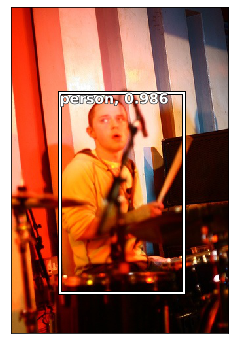

In [33]:
test_idx = 18

modelsaved = get_model_instance_segmentation(num_classes, True)

#SAVED_PATH = './k_model_2019.06.25.nn.pt'
#SAVED_PATH = './cocopretrained_withepoch3_2019.06.26.pt'

modelsaved.load_state_dict( torch.load(SAVED_PATH))

modelsaved.eval()
modelsaved.to(device)
img, _ = dataset_test[test_idx]
# put the model in evaluation mode
modelsaved.eval()
with torch.no_grad():
    prediction = modelsaved([img.to(device)])
    
PATH = Path('data/pascal')   
#jsonname = 'pascal_train2007.json' 
jsonname = 'pascal_val2007.json' 
trn_j = json.load( (PATH/jsonname).open() )
cats =  {o['id']:o['name'] for o in trn_j['categories']}
    
    
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects


#print(prediction[0]) # dict_keys(['boxes', 'labels', 'scores', 'masks'])
result = prediction[0]

#print(type(img))
toimg = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
ax = show_img(toimg, figsize=(6, 6)) 
threshold = 0.9
for box, score, label in zip(result['boxes'], result['scores'], result['labels']):    
    score = score.item()        
    if score <= threshold :
        break
    box = box.detach().cpu().clone().numpy()
    b = bb_hw(box)
    draw_rect(ax, b)
    print("label.item :", label.item())
    #resultscore = "{}, {:1.3f}".format( COCO_INSTANCE_CATEGORY_NAMES[label.item()], score )
    resultscore = "{}, {:1.3f}".format( cats[label.item()], score )
    
    
    draw_text(ax, b[:2], resultscore )
        
#plt.show()            